In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
font = {'size': 16}
matplotlib.rc('font', **font)
tqdm.tqdm.pandas()
import shapefile
from polylabel import polylabel

In [2]:
basedir = './연속지적_서울/'

In [3]:
foldernames = [f for f in os.listdir(basedir) if '.' not in f]
foldernames

['LSMD_CONT_LDREG_서울_강남구',
 'LSMD_CONT_LDREG_서울_강동구',
 'LSMD_CONT_LDREG_서울_강북구',
 'LSMD_CONT_LDREG_서울_강서구',
 'LSMD_CONT_LDREG_서울_관악구',
 'LSMD_CONT_LDREG_서울_광진구',
 'LSMD_CONT_LDREG_서울_구로구',
 'LSMD_CONT_LDREG_서울_금천구',
 'LSMD_CONT_LDREG_서울_노원구',
 'LSMD_CONT_LDREG_서울_도봉구',
 'LSMD_CONT_LDREG_서울_동대문구',
 'LSMD_CONT_LDREG_서울_동작구',
 'LSMD_CONT_LDREG_서울_마포구',
 'LSMD_CONT_LDREG_서울_서대문구',
 'LSMD_CONT_LDREG_서울_서초구',
 'LSMD_CONT_LDREG_서울_성동구',
 'LSMD_CONT_LDREG_서울_성북구',
 'LSMD_CONT_LDREG_서울_송파구',
 'LSMD_CONT_LDREG_서울_양천구',
 'LSMD_CONT_LDREG_서울_영등포구',
 'LSMD_CONT_LDREG_서울_용산구',
 'LSMD_CONT_LDREG_서울_은평구',
 'LSMD_CONT_LDREG_서울_종로구',
 'LSMD_CONT_LDREG_서울_중구',
 'LSMD_CONT_LDREG_서울_중랑구']

In [4]:
pnu_df = pd.read_csv('./Prepped Data/서울특별시 건축물대장 법정동 코드정보.csv', encoding='euc-kr')
print(pnu_df.shape)
pnu_df.head()

(94131, 9)


,시군구코드,법정동코드,행정동코드,시도명,시군구명,법정동명,행정동명,적용시작일,적용만료일
0,27290,11800,617,대구광역시,달서구,유천동,유천동,20211129,20211129
1,41210,10600,655,경기도,광명시,일직동,일직동,20211129,99991231
2,27290,11900,617,대구광역시,달서구,대천동,유천동,20211129,20211129
3,27290,12000,617,대구광역시,달서구,월성동,유천동,20211129,20211129
4,27290,12100,617,대구광역시,달서구,월암동,유천동,20211129,20211129


In [5]:
def intable(x):
    # x is a str or a number
    
    try:
        int(x)
        return 1
    except:
        return 0

In [6]:
%%time
count = 0

sigungu_name_list = []
bubjungdong_name_list = []
jibun_jimok_list = []
jibun_list = []
jimok_list = []
coor_x_list = []
coor_y_list = []

for folder in foldernames:
    print(folder)
    
    shp_filename = [f for f in os.listdir(basedir + folder) if '.shp' in f][0]
    shp_dir = basedir + folder + '/' + shp_filename
    
    sf = shapefile.Reader(shp_dir, encoding='euc-kr')
    
    for i in tqdm.tqdm_notebook(range(len(sf))):
        #points
        points = sf.shape(i).points
        
        labeled = polylabel([[list(p) for p in points]])
        
        coor_x = labeled[0]
        coor_y = labeled[1]       
        
        #records
        record = sf.record(i)
        
        pnu = record[0]
        jibun_jimok = record[1]        
        jibun_jimok_list.append(jibun_jimok)

        sigungu_code = int(pnu[:5])
        bubjungdong_code = int(pnu[5:10])
        
        jibun_jimok = jibun_jimok.replace(' ', '')
        jibun = jibun_jimok[:-1]
        jimok = jibun_jimok[-1]
        
        if intable(jimok) == 1:
            jibun = jibun_jimok
            jimok = '입력없음'
        
        '''splitted = jibun_jimok.split(' ')
        
        if len(splitted) <= 2:        
            jibun = splitted[0]
            try:
                jimok = splitted[1]
                
                if (len(jimok) != 1) | (intable(jimok) == 1):
                    jibun = ''.join
                
                
            except:        
                jibun = jibun_jimok[:-1]
                jimok = jibun_jimok[-1]
                
        else:
            jibun = ''.join(splitted[:-1])
            jimok = splitted[-1]'''

        target_df = pnu_df[(pnu_df['시군구코드'] == sigungu_code) & (pnu_df['법정동코드'] == bubjungdong_code)]
        
        #writing
        sigungu_name_list.append(target_df['시군구명'].iloc[0])
        bubjungdong_name_list.append(target_df['법정동명'].iloc[0])
        jibun_list.append(jibun)
        jimok_list.append(jimok)
        coor_x_list.append(coor_x)
        coor_y_list.append(coor_y)
        
        '''sf_df.loc[count, '시군구명'] = target_df['시군구명'].iloc[0]
        sf_df.loc[count, '법정동명'] = target_df['법정동명'].iloc[0]
        sf_df.loc[count, '지번'] = jibun
        sf_df.loc[count, '지목'] = jimok
        sf_df.loc[count, 'x좌표'] = coor_x
        sf_df.loc[count, 'y좌표'] = coor_y'''
        
        count += 1

LSMD_CONT_LDREG_서울_강남구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/34503 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_강동구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/30736 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_강북구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40487 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_강서구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/42882 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_관악구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/45471 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_광진구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/32810 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_구로구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/36590 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_금천구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/19914 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_노원구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20863 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_도봉구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/22877 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_동대문구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/41321 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_동작구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38868 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_마포구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/42629 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_서대문구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/41208 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_서초구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/34953 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_성동구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/26859 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_성북구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/54890 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_송파구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/32416 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_양천구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/22543 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_영등포구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/37824 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_용산구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/44900 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_은평구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/52737 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_종로구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/49207 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_중구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/35579 [00:00<?, ?it/s]

LSMD_CONT_LDREG_서울_중랑구


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/39251 [00:00<?, ?it/s]

Wall time: 23min 26s


In [11]:
sf_df = pd.DataFrame({
    '시군구명':sigungu_name_list, '법정동명':bubjungdong_name_list, '지번_지목':jibun_jimok_list, '지번':jibun_list,
    '지목':jimok_list, 'x좌표':coor_x_list, 'y좌표':coor_y_list
})

In [12]:
print(sf_df.shape)
sf_df.head()

(922318, 7)


,시군구명,법정동명,지번_지목,지번,지목,x좌표,y좌표
0,강남구,논현동,67-26 도,67-26,도,202648.630547,446277.538516
1,강남구,논현동,67-27 대,67-27,대,202676.093470,446297.563160
2,강남구,논현동,67-28 대,67-28,대,202584.375000,446275.930000
3,강남구,논현동,68 대,68,대,202695.885000,446317.525000
4,강남구,논현동,68-1 대,68-1,대,202707.844582,446324.121631


In [13]:
sf_df['지목'].value_counts()

대       681945
도       145987
임        20913
전        16087
답        10165
천         9336
잡         7656
구         6655
공         5793
철         4909
학         2986
종         2117
제         2007
장         1291
차         1080
주          813
수          626
사          464
묘          401
유          321
가          298
과          243
창          102
체           97
원           20
입력없음         5
목            1
Name: 지목, dtype: int64

In [14]:
inv_df = sf_df[sf_df['지목'] == '목']
print(inv_df.shape)
inv_df.head()

(1, 7)


,시군구명,법정동명,지번_지목,지번,지목,x좌표,y좌표
498907,서초구,내곡동,228-1목,228-1,목,205488.353438,439597.629312


In [15]:
inv_df = sf_df[sf_df['지목'] == '주']
print(inv_df.shape)
inv_df.head()

(813, 7)


,시군구명,법정동명,지번_지목,지번,지목,x좌표,y좌표
398,강남구,역삼동,668-13 주,668-13,주,203148.467100,444500.062804
803,강남구,율현동,527 주,527,주,210053.825586,441278.417961
908,강남구,수서동,522-1 주,522-1,주,208330.505375,442436.871125
2377,강남구,신사동,592-2 주,592-2,주,202454.510000,446695.510000
2403,강남구,신사동,638 주,638,주,202944.893938,447403.428129


In [18]:
%%time
sf_df.to_csv('./Prepped Data/연속지적도출처_지번별좌표_baseline_20211222.csv', index=False)

Wall time: 2.68 s


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='x좌표', ylabel='y좌표'>

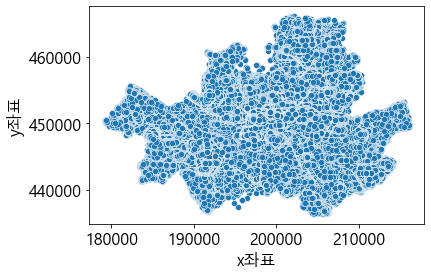

In [17]:
sns.scatterplot(sf_df['x좌표'], sf_df['y좌표'])